In [6]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import tensorflow as tf

tf.enable_eager_execution()
tf.executing_eagerly()

True

In [8]:
import numpy as np
import os
import copy

import Src.YamlUtils as yu
import Src.DicData as dade
import Src.Slideshow as slide
import Src.KerasSequence as ks
import Src.ImgProcessing as img_proc
import Src.OversampleStreamData as osa
import Src.Speed as speed
import Src.Models as models
import Src.KerasCallbacks as kc

In [9]:
import Src.Models as models

In [10]:
from keras.models import Model, Sequential, load_model
from keras.layers import InputLayer, Input, Dense, Flatten, Reshape, Dropout, Activation, Concatenate
from keras.layers import LSTM, CuDNNLSTM, GRU, CuDNNGRU, TimeDistributed
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras import backend as K
import keras as k
import tensorflow as tf

# MODELS

In [11]:
def generator_model(image_shape, batch_size=1, stateful=True, compile_model=True, optimizer="adam", bias=True):
    
    sequence_size = None
    img_batch_shape   = (batch_size, sequence_size, image_shape[0], image_shape[1], image_shape[2])
    speed_batch_shape = (batch_size, sequence_size, 1)

    # ARCHITECTURE BEGIN
    img_inputs = Input(batch_shape=img_batch_shape, name="img_input_gen")
    speed_inputs = Input(batch_shape=speed_batch_shape, name="speed_input_gen")
    

    # IMG PART
    conv01 = TimeDistributed(Conv2D(filters=32, kernel_size=(11, 11), padding="same", use_bias=bias), name="conv01_gen")(img_inputs)
    pool01 = TimeDistributed(MaxPooling2D(pool_size=(2, 2)), name="pool01_gen")(conv01)
    # norm01 = TimeDistributed(BatchNormalization(), name="conv_batch_norm01")(pool01)
    relu01 = TimeDistributed(Activation("relu"), name="conv_relu01_gen")(pool01)

    conv02 = TimeDistributed(Conv2D(filters=64, kernel_size=(5, 5), padding="same", use_bias=bias), name="conv02_gen")(relu01)
    pool02 = TimeDistributed(MaxPooling2D(pool_size=(2, 2)), name="pool02_gen")(conv02)
    # norm02 = TimeDistributed(BatchNormalization(), name="conv_batch_norm02")(pool02)
    relu02 = TimeDistributed(Activation("relu"), name="conv_relu02_gen")(pool02)

    conv03 = TimeDistributed(Conv2D(filters=128, kernel_size=(3, 3), padding="same", use_bias=bias), name="conv03_gen")(relu02)
    pool03 = TimeDistributed(MaxPooling2D(pool_size=(2, 2)), name="pool03_gen")(conv03)
    # norm03 = TimeDistributed(BatchNormalization(), name="conv_batch_norm03")(pool03)
    relu03 = TimeDistributed(Activation("relu"), name="conv_relu03_gen")(pool03)

    conv04 = TimeDistributed(Conv2D(filters=32, kernel_size=(3, 3), padding="same", use_bias=bias), name="conv04_gen")(relu03)
    pool04 = TimeDistributed(MaxPooling2D(pool_size=(2, 2)), name="pool04_gen")(conv04)
    # norm04 = TimeDistributed(BatchNormalization(), name="conv_batch_norm04")(pool04)
    relu04 = TimeDistributed(Activation("relu"), name="conv_relu04_gen")(pool04)

    flatten = TimeDistributed(Flatten(), name="flatten_gen")(relu04)
    
    speed_conc01 = Concatenate(name="speed_conc01_gen")([flatten, speed_inputs])

    speed_dens01 = TimeDistributed(Dense(32, use_bias=bias), name="speed_dense01_gen")(speed_conc01)
    # img_dens_norm01 = TimeDistributed(BatchNormalization(), name="img_dense_batch_norm01")(img_dens01)
    speed_dens_tanh01 = TimeDistributed(Activation("tanh"), name="speed_dense_tanh01_gen")(speed_dens01)
    # speed_dens_drop01 = TimeDistributed(Dropout(0.5), name="img_dense_dropout01")(img_dens_tanh01)
    
    speed_conc02 = Concatenate(name="speed_conc02_gen")([speed_dens_tanh01, speed_inputs])
    
    speed_dens02 = TimeDistributed(Dense(32, use_bias=bias), name="speed_dense02_gen")(speed_conc02)
    # img_dens_norm02 = TimeDistributed(BatchNormalization(), name="img_dense_batch_norm02")(img_dens02)
    speed_dens_tanh02 = TimeDistributed(Activation("tanh"), name="img_dense_tanh02_gen")(speed_dens02)
    # img_dens_drop02 = TimeDistributed(Dropout(0.5), name="img_dense_dropout02")(img_dens_tanh02)
    
    speed_conc03 = Concatenate(name="speed_conc03_gen")([speed_dens_tanh02, speed_inputs])
    
    lstm01 = LSTM(32, return_sequences=True, return_state=False, stateful=stateful, name="lstm01_gen")(speed_conc03)
    
    speed_outputs = TimeDistributed(Dense(1, activation='sigmoid'), name="speed_outputs_gen")(lstm01)
    
    # ARCHITECTURE END

    model = Model(inputs=[img_inputs, speed_inputs], outputs=[speed_outputs], name="generator")

    if compile_model:
        model.compile(loss={"speed_outputs_gen": "mae"},
                      optimizer=optimizer,
                      metrics={"speed_outputs_gen": "mae"},
                      sample_weight_mode="temporal")

    return model


def discriminator_model(image_shape, batch_size=1, stateful=True, compile_model=True, optimizer="adam", bias=True):
    
    sequence_size = None
    img_batch_shape   = (batch_size, sequence_size, image_shape[0], image_shape[1], image_shape[2])
    speed_batch_shape = (batch_size, sequence_size, 1)

    # ARCHITECTURE BEGIN
    img_inputs = Input(batch_shape=img_batch_shape, name="img_input")
    speed_inputs = Input(batch_shape=speed_batch_shape, name="speed_input")
    

    # IMG PART
    conv01 = TimeDistributed(Conv2D(filters=32, kernel_size=(11, 11), padding="same", use_bias=bias), name="conv01")(img_inputs)
    pool01 = TimeDistributed(MaxPooling2D(pool_size=(2, 2)), name="pool01")(conv01)
    # norm01 = TimeDistributed(BatchNormalization(), name="conv_batch_norm01")(pool01)
    relu01 = TimeDistributed(Activation("relu"), name="conv_relu01")(pool01)

    conv02 = TimeDistributed(Conv2D(filters=64, kernel_size=(5, 5), padding="same", use_bias=bias), name="conv02")(relu01)
    pool02 = TimeDistributed(MaxPooling2D(pool_size=(2, 2)), name="pool02")(conv02)
    # norm02 = TimeDistributed(BatchNormalization(), name="conv_batch_norm02")(pool02)
    relu02 = TimeDistributed(Activation("relu"), name="conv_relu02")(pool02)

    conv03 = TimeDistributed(Conv2D(filters=128, kernel_size=(3, 3), padding="same", use_bias=bias), name="conv03")(relu02)
    pool03 = TimeDistributed(MaxPooling2D(pool_size=(2, 2)), name="pool03")(conv03)
    # norm03 = TimeDistributed(BatchNormalization(), name="conv_batch_norm03")(pool03)
    relu03 = TimeDistributed(Activation("relu"), name="conv_relu03")(pool03)

    conv04 = TimeDistributed(Conv2D(filters=32, kernel_size=(3, 3), padding="same", use_bias=bias), name="conv04")(relu03)
    pool04 = TimeDistributed(MaxPooling2D(pool_size=(2, 2)), name="pool04")(conv04)
    # norm04 = TimeDistributed(BatchNormalization(), name="conv_batch_norm04")(pool04)
    relu04 = TimeDistributed(Activation("relu"), name="conv_relu04")(pool04)

    flatten = TimeDistributed(Flatten(), name="flatten")(relu04)
    
    speed_conc01 = Concatenate(name="speed_conc01")([flatten, speed_inputs])

    speed_dens01 = TimeDistributed(Dense(32, use_bias=bias), name="speed_dense01")(speed_conc01)
    # img_dens_norm01 = TimeDistributed(BatchNormalization(), name="img_dense_batch_norm01")(img_dens01)
    speed_dens_tanh01 = TimeDistributed(Activation("tanh"), name="speed_dense_tanh01")(speed_dens01)
    # speed_dens_drop01 = TimeDistributed(Dropout(0.5), name="img_dense_dropout01")(img_dens_tanh01)
    
    speed_conc02 = Concatenate(name="speed_conc02")([speed_dens_tanh01, speed_inputs])
    
    speed_dens02 = TimeDistributed(Dense(32, use_bias=bias), name="speed_dense02")(speed_conc02)
    # img_dens_norm02 = TimeDistributed(BatchNormalization(), name="img_dense_batch_norm02")(img_dens02)
    speed_dens_tanh02 = TimeDistributed(Activation("tanh"), name="img_dense_tanh02")(speed_dens02)
    # img_dens_drop02 = TimeDistributed(Dropout(0.5), name="img_dense_dropout02")(img_dens_tanh02)
    
    speed_conc03 = Concatenate(name="speed_conc03")([speed_dens_tanh02, speed_inputs])
    
    lstm01 = LSTM(32, return_sequences=True, return_state=False, stateful=stateful, name="lstm01")(speed_conc03)
    
    speed_outputs = TimeDistributed(Dense(1, activation='sigmoid'), name="speed_outputs")(lstm01)
    
    # ARCHITECTURE END

    model = Model(inputs=[img_inputs, speed_inputs], outputs=[speed_outputs], name="discriminator")

    if compile_model:
        model.compile(loss={"speed_outputs": "binary_crossentropy"},
                      optimizer=optimizer,
                      metrics={"speed_outputs": "accuracy"},
                      sample_weight_mode="temporal")

    return model

In [5]:
models.reset_session()

RuntimeError: `set_session` is not available when TensorFlow is executing eagerly.

In [12]:
def build_generator():
    builder = mb.SeqModelBuilder(generator_model, 
                                 "lstm",
                                 (64,64,3), 
                                 batch_size=1,
                                 stateful=True,
                                 compile_model=False,
                                 optimizer="adam",
                                 bias=True,
                                 weights_file=None)
    
    model = builder.build()
    
    return model

In [13]:
def build_discriminator():
    builder = mb.SeqModelBuilder(discriminator_model, 
                                 "lstm",
                                 (64,64,3), 
                                 batch_size=1,
                                 stateful=True,
                                 compile_model=True,
                                 optimizer="adam",
                                 bias=True,
                                 weights_file=None)
    
    model = builder.build()
    
    return model

In [14]:
def build_gan(gen, dis):
    
    sequence_size = None
    img_batch_shape   = (1, sequence_size, 64, 64, 3)
    speed_batch_shape = (1, sequence_size, 1)

    img_inputs = Input(batch_shape=img_batch_shape, name="img_input_gan")
    speed_inputs = Input(batch_shape=speed_batch_shape, name="speed_input_gan")
    
    gen_speeds = gen._internal_model([img_inputs, speed_inputs])
    
    dis._internal_model.trainable = False
    validity = dis._internal_model([img_inputs, gen_speeds])
    
    gan = Model([img_inputs, speed_inputs], validity, name="gan")
    gan.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    
    return gan

In [15]:
import Src.ModelBuilder as mb

In [16]:
generator = build_generator()
discriminator = build_discriminator()

generator._internal_model._make_predict_function()
discriminator._internal_model._make_predict_function()

TypeError: 'Tensor' object cannot be interpreted as an integer

In [116]:
print(generator._internal_model.summary())
print("##################################################################")
print()

print(discriminator._internal_model.summary())
print("##################################################################")

Model: "generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img_input_gen (InputLayer)      (1, None, 64, 64, 3) 0                                            
__________________________________________________________________________________________________
conv01_gen (TimeDistributed)    (1, None, 64, 64, 32 11648       img_input_gen[0][0]              
__________________________________________________________________________________________________
pool01_gen (TimeDistributed)    (1, None, 32, 32, 32 0           conv01_gen[0][0]                 
__________________________________________________________________________________________________
conv_relu01_gen (TimeDistribute (1, None, 32, 32, 32 0           pool01_gen[0][0]                 
__________________________________________________________________________________________

In [117]:
gan = build_gan(generator, discriminator)

In [118]:
print(gan.summary())

Model: "gan"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img_input_gan (InputLayer)      (1, None, 64, 64, 3) 0                                            
__________________________________________________________________________________________________
speed_input_gan (InputLayer)    (1, None, 1)         0                                            
__________________________________________________________________________________________________
generator (Model)               (1, None, 1)         199681      img_input_gan[0][0]              
                                                                 speed_input_gan[0][0]            
__________________________________________________________________________________________________
discriminator (Model)           (1, None, 1)         199681      img_input_gan[0][0]            

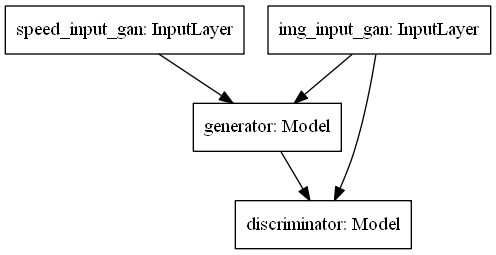

In [119]:
tf.keras.utils.plot_model(
    gan,
    to_file="gan.png",
    show_shapes=False,
    show_layer_names=True,
    )


# DATA

In [15]:
img_path = "Z:/ForschB/NeuroRace-Sim/forschB_data/{}/depth_camera/rgb/image_raw/compressed"
train_path = "Z:/ForschB/NeuroRace-Sim/forschB_data"

valid_img_path = "Z:/ForschB/NeuroRace-Sim/forschB_data_counter/{}/depth_camera/rgb/image_raw/compressed"
valid_path = "Z:/ForschB/NeuroRace-Sim/forschB_data_counter"


dirs = os.listdir(train_path)
valid_dirs = os.listdir(valid_path)


yamls = []

for d in dirs:
    yamls.append("{}/{}/{}.yaml".format(train_path, d, d))
    
    
valid_yamls = []

for d in valid_dirs:
    valid_yamls.append("{}/{}/{}.yaml".format(valid_path, d, d))

In [16]:
dicts = []

for y in yamls:
    dicts.append(dade.convert_neuro_data_to_yaml(y))
    
valid_dicts = []

for y in valid_yamls:
    valid_dicts.append(dade.convert_neuro_data_to_yaml(y))

In [17]:
def do_all(dic):
    dade.remove_data_with_speed_lower_than_threshold(dic)
    max_abs_speed, max_abs_steer = dade.get_max_abs_speed_and_steering(dic)
    
    # dade.add_speed_classes_to_dic(dic, threshold=0.05)
    
    # dade.normalize_dic_steering(dic, max_abs_steer)
    dade.normalize_dic_speed(dic, 10)
    
    dade.add_speed_classes_to_dic_like_steering(dic)
    
    for k in dic.keys():
        
        if "speed_class" not in dic[k].keys():
            print(k)
            print(type(k))
    
    
    dade.add_steer_classes_to_dic(dic)
    dade.add_speed_cost_weight_to_dic(dic)
    dade.add_steer_cost_weight_to_dic_classifier(dic)
    
    return max_abs_steer, max_abs_speed

In [18]:
max_steers = []
max_speeds = []

for d in dicts:
    max_steer, max_speed = do_all(d)
    max_steers.append(max_steer)
    max_speeds.append(max_speed)
    
for d in valid_dicts:
    _, _ = do_all(d)

In [24]:
img_processor = img_proc.ImgProcessor()

img_processor.crop = True
img_processor.augment = False

img_processor.fx = 0.1
img_processor.fy = 0.2

In [25]:
batch_size = 1
sequence_size = 64

In [26]:
speed_gens = []

for f, d in zip(dicts, dirs):
    
    gen = ks.SequenceGeneratorSpeedRegression(f, img_path.format(d), img_processor, 
                                    batch_size=1, sequence_size=sequence_size, img_file_type="jpg")
    gen.return_weights = False
    
    speed_gens.append(gen)

In [27]:
valid_speed_gens = []

for f, d in zip(valid_dicts, valid_dirs):
    
    gen = ks.SequenceGeneratorSpeedRegression(f, valid_img_path.format(d), img_processor, 
                                    batch_size=1, sequence_size=sequence_size, img_file_type="jpg")
    gen.return_weights = False
    
    valid_speed_gens.append(gen)

# TRAINING

In [120]:
print(generator._internal_model.predict([np.zeros([1,1,64,64,3]), np.asarray([[[0.0]]])], batch_size=1))
print(discriminator._internal_model.predict([np.zeros([1,1,64,64,3]), np.asarray([[[0.0]]])], batch_size=1))

[[[0.5]]]
[[[0.5]]]


In [83]:
from collections import deque

In [134]:
# https://www.youtube.com/watch?v=T-MCludVNn4

def train(generator, discriminator, gan, gen, epochs=1):
    
    y_previous = 0.0
    y_previous_last_batch = 0.0
    
    y_real = np.ones((1, 64, 1))
    y_fake = np.zeros((1, 64, 1))
    y_predicted = deque([0.0 for _ in range(64)], maxlen=64)
    
    generator.set_internal_tensors()
    discriminator.set_internal_tensors()
    
    tf_session = K.get_session()
    
    for e in range(epochs):
    
        for [x_batch, pre_y_batch], [y_batch] in gen:
            
            generator.set_internal_values(tf_session)
            discriminator.set_internal_values(tf_session)
            
            for x_seq, y_seq in zip(x_batch, y_batch):
                
                for x, y in zip(x_seq, y_seq):
                    
                    y_predicted.append(np.asscalar(generator.predict([[[x]], [[[y_previous]]]], batch_size=1)))
                    
                    y_previous = y_predicted[-1]
                    
                # generator.assign_internal_values(tf_session)
            
            d_loss_real = discriminator._internal_model.train_on_batch([x_batch, y_batch], [y_real])
            # discriminator.assign_internal_values(tf_session)
            
            speeds_fake = np.expand_dims(np.asarray([y_predicted]), axis=2)
            d_loss_fake = discriminator._internal_model.train_on_batch([x_batch, speeds_fake], [y_fake])
            # discriminator.assign_internal_values(tf_session)
            
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            
            
            tmp = [[y_previous_last_batch] + list(y_predicted)[:-1]]
            speeds_fake = np.expand_dims(np.asarray( tmp ), axis=2)
            g_loss = gan.train_on_batch([x_batch, pre_y_batch], [y_real])
            
            y_previous_last_batch = y_previous
            
            print("{} [D loss: {}, acc.: {}] [G loss: {}]".format(e, d_loss[0], 100*d_loss[1], g_loss))
                

In [137]:
generator.reset_states()
discriminator.reset_states()

train(generator=generator, discriminator=discriminator, gan=gan, gen=speed_gens[0], epochs=10)

0 [D loss: 0.6652770042419434, acc.: 74.21875] [G loss: [0.7860413, 0.0]]
0 [D loss: 0.6867178678512573, acc.: 51.5625] [G loss: [0.79020554, 0.0]]
0 [D loss: 0.6332088708877563, acc.: 88.28125] [G loss: [0.78152525, 0.0]]
0 [D loss: 0.6330461502075195, acc.: 88.28125] [G loss: [0.75721216, 0.0]]
0 [D loss: 0.6418470740318298, acc.: 83.59375] [G loss: [0.71436024, 0.0]]
0 [D loss: 0.5666379928588867, acc.: 61.71875] [G loss: [0.6832055, 1.0]]
0 [D loss: 0.578393280506134, acc.: 60.9375] [G loss: [0.69442177, 0.203125]]
0 [D loss: 0.5447552800178528, acc.: 75.78125] [G loss: [0.74342537, 0.0]]
0 [D loss: 0.7100181579589844, acc.: 54.6875] [G loss: [0.8092038, 0.0]]
0 [D loss: 0.618079662322998, acc.: 78.90625] [G loss: [0.8733214, 0.0]]
0 [D loss: 0.6715033650398254, acc.: 50.0] [G loss: [0.91503996, 0.0]]
0 [D loss: 0.6757869720458984, acc.: 50.0] [G loss: [0.9206425, 0.0]]
0 [D loss: 0.6378523111343384, acc.: 63.28125] [G loss: [0.8783586, 0.0]]
0 [D loss: 0.7428926229476929, acc.: 50

1 [D loss: 0.8312027454376221, acc.: 16.40625] [G loss: [0.6858814, 1.0]]
1 [D loss: 0.5891183614730835, acc.: 54.6875] [G loss: [0.70964956, 0.140625]]
1 [D loss: 0.5313980579376221, acc.: 61.71875] [G loss: [0.77109146, 0.0]]
1 [D loss: 0.5153961181640625, acc.: 92.96875] [G loss: [0.8270345, 0.0]]
1 [D loss: 0.8098199367523193, acc.: 50.0] [G loss: [0.9357679, 0.0]]
1 [D loss: 0.6897789239883423, acc.: 50.0] [G loss: [0.9750053, 0.0]]
1 [D loss: 0.7223212718963623, acc.: 50.0] [G loss: [0.9778921, 0.0]]
1 [D loss: 0.5621321201324463, acc.: 75.0] [G loss: [0.98415256, 0.0]]
1 [D loss: 0.45374032855033875, acc.: 85.15625] [G loss: [0.9897655, 0.0]]
1 [D loss: 0.7391420602798462, acc.: 50.0] [G loss: [0.9837178, 0.0]]
1 [D loss: 0.7317909598350525, acc.: 50.0] [G loss: [0.9706358, 0.0]]
1 [D loss: 0.5894569158554077, acc.: 69.53125] [G loss: [0.96228075, 0.0]]
1 [D loss: 0.4341028332710266, acc.: 89.84375] [G loss: [0.95968485, 0.0]]
1 [D loss: 0.7159838676452637, acc.: 50.0] [G loss: 

2 [D loss: 0.48935019969940186, acc.: 96.09375] [G loss: [1.0304983, 0.0]]
2 [D loss: 0.5251562595367432, acc.: 96.09375] [G loss: [1.054628, 0.0]]
2 [D loss: 0.4706750214099884, acc.: 93.75] [G loss: [1.0825346, 0.0]]
2 [D loss: 0.4591314196586609, acc.: 95.3125] [G loss: [1.1128287, 0.0]]
2 [D loss: 0.4684079885482788, acc.: 94.53125] [G loss: [1.1427183, 0.0]]
2 [D loss: 0.429399311542511, acc.: 94.53125] [G loss: [1.1764034, 0.0]]
2 [D loss: 0.426330029964447, acc.: 96.09375] [G loss: [1.2111739, 0.0]]
2 [D loss: 0.45591145753860474, acc.: 89.0625] [G loss: [1.2428677, 0.0]]
2 [D loss: 0.38167890906333923, acc.: 92.96875] [G loss: [1.2823443, 0.0]]
2 [D loss: 0.36974653601646423, acc.: 92.96875] [G loss: [1.3289464, 0.0]]
2 [D loss: 0.361949622631073, acc.: 94.53125] [G loss: [1.3794222, 0.0]]
2 [D loss: 0.3934616148471832, acc.: 91.40625] [G loss: [1.426275, 0.0]]
2 [D loss: 0.5239002108573914, acc.: 75.78125] [G loss: [1.4376872, 0.0]]
2 [D loss: 0.7620154619216919, acc.: 50.0] [

3 [D loss: 0.7572356462478638, acc.: 50.0] [G loss: [1.0352964, 0.0]]
3 [D loss: 0.6666679978370667, acc.: 57.03125] [G loss: [1.0525308, 0.0]]
3 [D loss: 0.6879705190658569, acc.: 50.0] [G loss: [1.0599167, 0.0]]
3 [D loss: 0.6603396534919739, acc.: 57.8125] [G loss: [1.0590199, 0.0]]
3 [D loss: 0.5831642150878906, acc.: 70.3125] [G loss: [1.0549245, 0.0]]
3 [D loss: 0.6918432116508484, acc.: 50.0] [G loss: [1.0403621, 0.0]]
3 [D loss: 0.7116155028343201, acc.: 50.0] [G loss: [1.0152224, 0.0]]
3 [D loss: 0.7020253539085388, acc.: 50.0] [G loss: [0.98214704, 0.0]]
3 [D loss: 0.7074247598648071, acc.: 50.0] [G loss: [0.94312394, 0.0]]
3 [D loss: 0.742624044418335, acc.: 50.0] [G loss: [0.90072554, 0.0]]
3 [D loss: 0.6137890815734863, acc.: 73.4375] [G loss: [0.8629316, 0.0]]
3 [D loss: 0.5723336935043335, acc.: 97.65625] [G loss: [0.83108044, 0.0]]
3 [D loss: 0.6558828949928284, acc.: 64.84375] [G loss: [0.79972243, 0.0]]
3 [D loss: 0.5556173920631409, acc.: 94.53125] [G loss: [0.772780

4 [D loss: 0.37180274724960327, acc.: 89.0625] [G loss: [1.303103, 0.0]]
4 [D loss: 0.37698957324028015, acc.: 88.28125] [G loss: [1.3576934, 0.0]]
4 [D loss: 0.35409659147262573, acc.: 89.84375] [G loss: [1.4011788, 0.0]]
4 [D loss: 0.8234379887580872, acc.: 50.0] [G loss: [1.4102827, 0.0]]
4 [D loss: 0.8380147218704224, acc.: 50.0] [G loss: [1.3916698, 0.0]]
4 [D loss: 0.8412325382232666, acc.: 50.0] [G loss: [1.3557943, 0.0]]
4 [D loss: 0.5087999105453491, acc.: 75.78125] [G loss: [1.3181009, 0.0]]
4 [D loss: 0.7875774502754211, acc.: 50.0] [G loss: [1.261768, 0.0]]
4 [D loss: 0.5912332534790039, acc.: 69.53125] [G loss: [1.1993902, 0.0]]
4 [D loss: 0.424574613571167, acc.: 82.8125] [G loss: [1.1383096, 0.0]]
4 [D loss: 0.794145405292511, acc.: 50.0] [G loss: [1.0592151, 0.0]]
4 [D loss: 0.818217933177948, acc.: 50.0] [G loss: [0.99162436, 0.0]]
4 [D loss: 0.7912139296531677, acc.: 50.0] [G loss: [0.9277337, 0.0]]
4 [D loss: 0.8187552690505981, acc.: 50.0] [G loss: [0.8925828, 0.0]]

5 [D loss: 0.5112208127975464, acc.: 61.71875] [G loss: [1.4667089, 0.0]]
5 [D loss: 0.5007950663566589, acc.: 74.21875] [G loss: [1.4548042, 0.0]]
5 [D loss: 0.22652825713157654, acc.: 95.3125] [G loss: [1.4408793, 0.0]]
5 [D loss: 0.4342799782752991, acc.: 79.6875] [G loss: [1.4076017, 0.0]]
5 [D loss: 0.7605045437812805, acc.: 50.0] [G loss: [1.3278221, 0.0]]
5 [D loss: 0.34984639286994934, acc.: 88.28125] [G loss: [1.2485893, 0.0]]
5 [D loss: 0.2969629168510437, acc.: 93.75] [G loss: [1.1933532, 0.0]]
5 [D loss: 0.3140116333961487, acc.: 92.96875] [G loss: [1.1684775, 0.0]]
5 [D loss: 0.27782177925109863, acc.: 96.09375] [G loss: [1.1772951, 0.0]]
5 [D loss: 0.4824099838733673, acc.: 76.5625] [G loss: [1.178206, 0.0]]
5 [D loss: 0.2879798114299774, acc.: 94.53125] [G loss: [1.20458, 0.0]]
5 [D loss: 0.2719942033290863, acc.: 95.3125] [G loss: [1.2536044, 0.0]]
5 [D loss: 0.28150495886802673, acc.: 93.75] [G loss: [1.3181195, 0.0]]
5 [D loss: 0.26046058535575867, acc.: 95.3125] [G l

7 [D loss: 0.40066957473754883, acc.: 86.71875] [G loss: [1.1397455, 0.0]]
7 [D loss: 0.40300798416137695, acc.: 87.5] [G loss: [1.156311, 0.0]]
7 [D loss: 0.37664994597435, acc.: 88.28125] [G loss: [1.1925962, 0.0]]
7 [D loss: 0.3314560353755951, acc.: 90.625] [G loss: [1.2345423, 0.0]]
7 [D loss: 0.4922003149986267, acc.: 89.0625] [G loss: [1.2010648, 0.0]]
7 [D loss: 0.7581194043159485, acc.: 50.0] [G loss: [1.135575, 0.0]]
7 [D loss: 0.7581984996795654, acc.: 50.0] [G loss: [1.03094, 0.0]]
7 [D loss: 0.48718664050102234, acc.: 80.46875] [G loss: [0.9709693, 0.0]]
7 [D loss: 0.46427392959594727, acc.: 83.59375] [G loss: [0.9953446, 0.0]]
7 [D loss: 0.39343392848968506, acc.: 88.28125] [G loss: [1.0661314, 0.0]]
7 [D loss: 0.3553120195865631, acc.: 90.625] [G loss: [1.1417983, 0.0]]
7 [D loss: 0.2765558063983917, acc.: 96.09375] [G loss: [1.2063925, 0.0]]
7 [D loss: 0.6616495847702026, acc.: 50.0] [G loss: [1.2193612, 0.0]]
7 [D loss: 0.7600497007369995, acc.: 50.0] [G loss: [1.20208

8 [D loss: 0.6228401064872742, acc.: 39.0625] [G loss: [0.7117623, 0.15625]]
8 [D loss: 0.6099739670753479, acc.: 72.65625] [G loss: [1.0165381, 0.0]]
8 [D loss: 0.3628673255443573, acc.: 89.84375] [G loss: [1.221118, 0.0]]
8 [D loss: 0.6704490184783936, acc.: 53.90625] [G loss: [1.2786261, 0.0]]
8 [D loss: 0.28617122769355774, acc.: 94.53125] [G loss: [1.3089924, 0.0]]
8 [D loss: 0.2773582637310028, acc.: 94.53125] [G loss: [1.3271315, 0.0]]
8 [D loss: 0.6365798711776733, acc.: 65.625] [G loss: [1.3302441, 0.0]]
8 [D loss: 0.32087379693984985, acc.: 92.1875] [G loss: [1.3336676, 0.0]]
8 [D loss: 0.28151261806488037, acc.: 95.3125] [G loss: [1.3390104, 0.0]]
8 [D loss: 0.2758549451828003, acc.: 94.53125] [G loss: [1.3480488, 0.0]]
8 [D loss: 0.6075204014778137, acc.: 67.96875] [G loss: [1.351171, 0.0]]
8 [D loss: 0.7127660512924194, acc.: 58.59375] [G loss: [1.3462551, 0.0]]
8 [D loss: 0.2520749568939209, acc.: 95.3125] [G loss: [1.3468852, 0.0]]
8 [D loss: 0.6298199892044067, acc.: 66

9 [D loss: 0.6923895478248596, acc.: 62.5] [G loss: [1.6488879, 0.0]]
9 [D loss: 0.2917045056819916, acc.: 90.625] [G loss: [1.6304199, 0.0]]
9 [D loss: 0.2540512979030609, acc.: 92.96875] [G loss: [1.6143988, 0.0]]
9 [D loss: 0.3592187762260437, acc.: 87.5] [G loss: [1.6161677, 0.0]]
9 [D loss: 0.2523346245288849, acc.: 92.96875] [G loss: [1.6345633, 0.0]]
9 [D loss: 0.3671116828918457, acc.: 84.375] [G loss: [1.6447895, 0.0]]
9 [D loss: 0.7969232797622681, acc.: 60.15625] [G loss: [1.636203, 0.0]]
9 [D loss: 0.22552590072155, acc.: 94.53125] [G loss: [1.6415123, 0.0]]
9 [D loss: 0.2297685742378235, acc.: 94.53125] [G loss: [1.6551474, 0.0]]
9 [D loss: 0.17074665427207947, acc.: 97.65625] [G loss: [1.6743454, 0.0]]
9 [D loss: 0.26918643712997437, acc.: 93.75] [G loss: [1.6772671, 0.0]]
9 [D loss: 0.3773666024208069, acc.: 85.9375] [G loss: [1.6770451, 0.0]]
9 [D loss: 0.22842609882354736, acc.: 94.53125] [G loss: [1.6835649, 0.0]]
9 [D loss: 0.22729037702083588, acc.: 94.53125] [G los